# 교통 데이터 VDS을 이용한 머신러닝 분류 
## k-NN

## I. 데이터 가져오기 
- 판다스를 이용하여 교통 데이터 가져오기

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('./daejeon_vds16.csv')
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc403680590>],
      dtype=object)

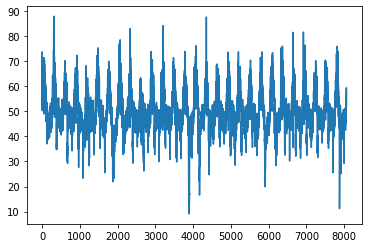

In [5]:
# 교통량 그림 그려보기
df_plt = df['Speed']
df_plt.plot(subplots=True)

- 5분 간격 데이터를 하루 동안 수집하면 그 갯수는 12(1시간) * 24 = 288
- 하루 동안 데이터를 그려보자 

## II. 라벨을 정하기
- 지도학습을 위해서 데이터를 Feature와 Label로 나누자.
- 무엇이 Feature이며 무엇이 Label 인가?
- 라벨은 무엇으로 정하는게 좋은가? 

In [6]:
def get_score(v):
    if v < 30:
        score = 'Jam'
    elif v < 50:
        score = 'Slow'
    else :
        score = 'Normal'
    return score

In [7]:
df["label_speed"] = df["Speed"].apply(lambda v: get_score(v))
df.head(5)

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate,label_speed
0,2017-04-02 0:00,43,34,9,0,50.3,1.90,Normal
1,2017-04-02 0:05,45,32,13,0,58.9,1.84,Normal
2,2017-04-02 0:10,46,34,12,0,50.6,1.87,Normal
3,2017-04-02 0:15,45,36,9,0,50.9,1.72,Normal
4,2017-04-02 0:20,27,13,13,1,62.2,1.12,Normal


### 라벨을 위해 'label'의 텍스트는 범주형 혹은 숫자로 인코딩 해야한다

## 3. 데이터 가시화 

In [8]:
import matplotlib.pyplot as plt

## 4 머신러닝을 위한 입력 데이터 만들자
- 우선 무슨 문제를 풀어야 하는가?
- 지도학습이며 라벨이 있고, 제일 먼저 해보는 것은 분류를 해보자
- 즉, 교통 속도 라벨을 이용하여 해당 도로의 교통 흐름을 분류해보고 정확도를 논의하자

### 1) 입력 X와 출력 y의 값을 정하기

In [9]:
df['label_speed'].unique()

array(['Normal', 'Slow', 'Jam'], dtype=object)

- 머신러닝에서 특징(Feature)에 대하여, 그리고 라벨에 대하여 다시한번 복습합시다 

In [10]:
#feature_cols = ['ToVol', 'SmVol', 'Speed', 'Occ.Rate']
#feature_cols = ['ToVol', 'SmVol', 'LaVol', 'MeVol']
feature_cols = ['ToVol','Occ.Rate','LaVol', 'MeVol']

target_col = 'label_speed'
X = df[feature_cols]
y = df[target_col]

### 2) 출력용 라벨을 머신러닝 
- 텍스트를 숫자로 바꾸자
- One-Hot Encoding
- 자연어 처리에는 Embedding을 사용함. 
- Word2Vec 

In [11]:
class_dic = {'Jam':0, 'Slow':1, 'Normal':2}
y_ohc = y.apply(lambda z: class_dic[z])

In [12]:
y_ohc.head()

0    2
1    2
2    2
3    2
4    2
Name: label_speed, dtype: int64

### 3) 데이터를 훈련과 테스트로 나누자 
- (실전) 데이터를 validation을 포함해서 나눌수 있다.
- (해보기) 전체 데이터를 train : validation : test = 0.6: 0.2: 0.2 로 나누어라

In [13]:
from sklearn.model_selection import train_test_split

#from sklearn.model_selection import learning_curve, train_test_split, KFold,  ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y_ohc, test_size=0.20, random_state=30)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(6451, 4) (6451,)
(1613, 4) (1613,)


- 머신러닝에서는 훈련과정에서 입력 특징 데이터를 표준화, 정규화를 한다.
- 왜?

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5. 머신러닝 모델을 만들자

In [16]:
import numpy as np
def plot_ml_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20)):   
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc='lower right')
    return plt

### 3 K-Nearest Neighbours

In [17]:
from sklearn.neighbors import KNeighborsClassifier 

- class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

- n_neighbors :  default=5

In [18]:
from sklearn import metrics   
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import ShuffleSplit, learning_curve

In [19]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=9)

In [20]:
pred = model.predict(X_test)
metrics.accuracy_score(pred,y_test)

0.8710477371357719

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

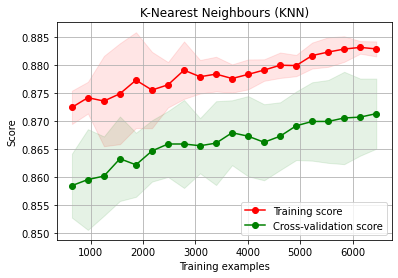

In [21]:
title = "K-Nearest Neighbours (KNN)"
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)

plot_ml_curve(model, title, X, y,  cv=cv, n_jobs=4)

#### 3.1 최적의 k-NN의 정확도 확인 

([<matplotlib.axis.XTick at 0x7fc3f03ae310>,
 <a list of 10 Text major ticklabel objects>)

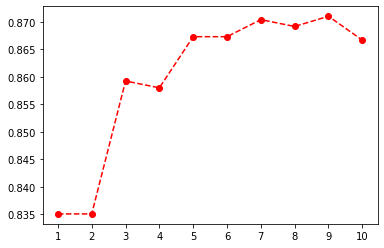

In [22]:
a_index = list(range(1,11))
a = pd.Series()
x = [1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    kcs = KNeighborsClassifier(n_neighbors=i) 
    kcs.fit(X_train,y_train)
    y_pred = kcs.predict(X_test)
    a=a.append(pd.Series(
        metrics.accuracy_score(y_pred,y_test)))
    
plt.plot(a_index, a,'ro--')
plt.xticks(x)

In [23]:
from sklearn.svm import SVC 

In [24]:
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)


In [25]:
metrics.accuracy_score(pred, y_test)

0.8747675139491631

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

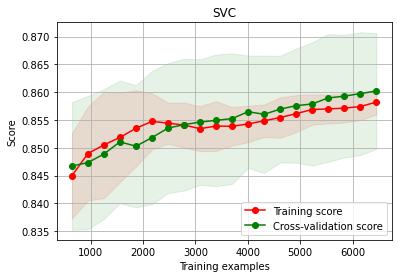

In [26]:
title='SVC'
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)
plot_ml_curve(model, title, X, y,  cv=cv)

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
model = RandomForestClassifier(n_estimators=100, max_depth=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
metrics.accuracy_score(pred, y_test)

0.8561686298822071

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

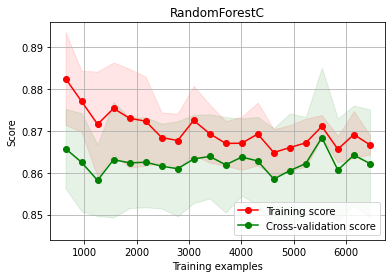

In [29]:
title='RandomForestC'
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)
plot_ml_curve(model, title, X, y,  cv=cv)

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
metrics.accuracy_score(pred, y_test)

0.8183508989460633

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

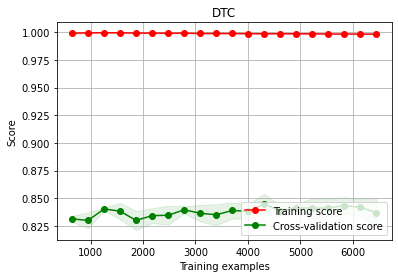

In [32]:
title='DTC'
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)
plot_ml_curve(model, title, X, y,  cv=cv)

In [33]:
import tensorflow as tf




ModuleNotFoundError: ignored

In [34]:
import tensorflow as tf

In [35]:
from tensorflow import keras

In [36]:
from tensorflow.keras import Sequential, optimizers

In [38]:
from tensorflow.keras.layers import Flatten, Dense, Softmax

In [43]:
num_features = len(X_train[1])
num_features

4

In [44]:
model = Sequential([
                    Dense(64, activation='relu',input_shape=[num_features]),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(3, activation='softmax')
])

In [48]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam', metrics=['accuracy'])

In [49]:
history = model.fit(X_train,y_train, epochs=100,
                    validation_data=(X_test,y_test),
                    batch_size=32, verbose=2)

Epoch 1/100
202/202 - 5s - loss: 0.4374 - accuracy: 0.8492 - val_loss: 0.3439 - val_accuracy: 0.8636 - 5s/epoch - 25ms/step
Epoch 2/100
202/202 - 1s - loss: 0.3247 - accuracy: 0.8744 - val_loss: 0.3627 - val_accuracy: 0.8655 - 732ms/epoch - 4ms/step
Epoch 3/100
202/202 - 1s - loss: 0.3154 - accuracy: 0.8805 - val_loss: 0.3440 - val_accuracy: 0.8717 - 760ms/epoch - 4ms/step
Epoch 4/100
202/202 - 1s - loss: 0.3055 - accuracy: 0.8856 - val_loss: 0.3224 - val_accuracy: 0.8772 - 768ms/epoch - 4ms/step
Epoch 5/100
202/202 - 1s - loss: 0.3009 - accuracy: 0.8867 - val_loss: 0.3217 - val_accuracy: 0.8710 - 925ms/epoch - 5ms/step
Epoch 6/100
202/202 - 1s - loss: 0.2951 - accuracy: 0.8889 - val_loss: 0.3133 - val_accuracy: 0.8760 - 782ms/epoch - 4ms/step
Epoch 7/100
202/202 - 1s - loss: 0.2877 - accuracy: 0.8898 - val_loss: 0.3131 - val_accuracy: 0.8803 - 755ms/epoch - 4ms/step
Epoch 8/100
202/202 - 1s - loss: 0.2817 - accuracy: 0.8909 - val_loss: 0.2942 - val_accuracy: 0.8872 - 793ms/epoch - 4ms

In [50]:
model.evaluate(X_test,y_test)

51/51 [==============================] - 0s 3ms/step - loss: 0.3066 - accuracy: 0.8884


[0.30664196610450745, 0.8884066939353943]